In [1]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.jsonl hdfs://nn:9000/
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/


In [2]:
!hdfs dfs -ls hdfs://nn:9000/

Found 8 items
-rw-r--r--   1 root supergroup         75 2025-11-11 03:28 hdfs://nn:9000/languages.csv
drwxr-xr-x   - root supergroup          0 2025-11-11 02:53 hdfs://nn:9000/model
-rw-r--r--   1 root supergroup   12731821 2025-11-11 03:28 hdfs://nn:9000/problem_tests.csv
-rw-r--r--   1 root supergroup    2854960 2025-11-11 03:28 hdfs://nn:9000/problems.jsonl
-rw-r--r--   1 root supergroup  177825918 2025-11-11 03:28 hdfs://nn:9000/solutions.jsonl
-rw-r--r--   1 root supergroup        101 2025-11-11 03:28 hdfs://nn:9000/sources.csv
-rw-r--r--   1 root supergroup        555 2025-11-11 03:28 hdfs://nn:9000/tags.csv
drwxr-xr-x   - root supergroup          0 2025-11-10 02:57 hdfs://nn:9000/user


In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "1G")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/11 03:29:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
problems_df = spark.read.json("hdfs://nn:9000/problems.jsonl")
problems_df.limit(5).show()
(
    problems_df
    .write
    .mode("overwrite")
    .saveAsTable("problems")
)


+-------------+--------+---------+---------+---------------+----------+---------------+-------------------------+------------------+--------------------+-------------+----------+------------+------+----------+
|cf_contest_id|cf_index|cf_points|cf_rating|        cf_tags|difficulty|generated_tests|is_description_translated|memory_limit_bytes|                name|private_tests|problem_id|public_tests|source|time_limit|
+-------------+--------+---------+---------+---------------+----------+---------------+-------------------------+------------------+--------------------+-------------+----------+------------+------+----------+
|          322|       A|    500.0|     1000|            [0]|         7|             93|                    false|         256000000|322_A. Ciel and D...|           45|         1|           2|     2|         1|
|          760|       D|   1000.0|     1600|         [1, 2]|        10|             51|                    false|         256000000|  760_D. Travel Card|       

25/11/11 03:29:13 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
25/11/11 03:29:13 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
25/11/11 03:29:15 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
25/11/11 03:29:15 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.2
25/11/11 03:29:15 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
25/11/11 03:29:17 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
25/11/11 03:29:17 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
25/11/11 03:29:17 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
25/11/11 03:29:17 W

In [5]:

solutions_df = spark.read.json("hdfs://nn:9000/solutions.jsonl")
(
    solutions_df
    .write
    .mode("overwrite")
    .bucketBy(4, "language")
    .saveAsTable("solutions")
)


In [6]:
# confirm if the hive tables is saved successfully or not
!hdfs dfs -ls hdfs://nn:9000/user/hive/warehouse

Found 2 items
drwxr-xr-x   - root supergroup          0 2025-11-11 03:29 hdfs://nn:9000/user/hive/warehouse/problems
drwxr-xr-x   - root supergroup          0 2025-11-11 03:29 hdfs://nn:9000/user/hive/warehouse/solutions


In [7]:
languages_df = spark.read.csv("hdfs://nn:9000/languages.csv",
  header = True, # First row contains column names
  inferSchema = True
)
languages_df.createOrReplaceTempView("languages")


problem_tests_df = spark.read.csv(
    "hdfs://nn:9000/problem_tests.csv",
    header=True,  # First row contains column names
    inferSchema=True 
)
problem_tests_df.createOrReplaceTempView("problem_tests")


sources_df = spark.read.csv(
    "hdfs://nn:9000/sources.csv",
    header=True,  # First row contains column names
    inferSchema=True 
)
sources_df.createOrReplaceTempView("sources")



tags_df = spark.read.csv("hdfs://nn:9000/tags.csv",
    header=True,  # First row contains column names
    inferSchema=True     
)
tags_df.createOrReplaceTempView("tags")


In [8]:
problems_df.printSchema()

root
 |-- cf_contest_id: long (nullable = true)
 |-- cf_index: string (nullable = true)
 |-- cf_points: double (nullable = true)
 |-- cf_rating: long (nullable = true)
 |-- cf_tags: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- difficulty: long (nullable = true)
 |-- generated_tests: long (nullable = true)
 |-- is_description_translated: boolean (nullable = true)
 |-- memory_limit_bytes: long (nullable = true)
 |-- name: string (nullable = true)
 |-- private_tests: long (nullable = true)
 |-- problem_id: long (nullable = true)
 |-- public_tests: long (nullable = true)
 |-- source: long (nullable = true)
 |-- time_limit: long (nullable = true)



# PART 1

## Q1: How many problems are there with a cf_rating of at least 1600, having private_tests, and a name containing "_A." (Case Sensitive)? Answer using all three Spark APIs.

In [9]:
#q1 


# RDD API

problems_rdd = problems_df.rdd

rdd_count = (
    problems_rdd.
    filter(lambda row : row.cf_rating >= 1600 and row.private_tests > 0 and "_A." in row.name)
    .count()
)

#############

# DATAFRAME API

dataframe_count = problems_df.filter(
    (problems_df.cf_rating >= 1600) &
    (problems_df.private_tests > 0) &
    problems_df.name.contains("_A.")
).count()

##############

# SPARK SQL API

sql_count = spark.sql("""
    SELECT COUNT(*) as count
    FROM problems
    WHERE cf_rating >= 1600
      AND private_tests > 0
      AND name LIKE '%_A.%'
""").collect()[0]['count']

###############

rdd_count, dataframe_count, sql_count


(217, 217, 217)

In [10]:
solutions_df.limit(50).show()

+----------+--------+----------+--------------------+
|is_correct|language|problem_id|            solution|
+----------+--------+----------+--------------------+
|      true| PYTHON2|         1|n,m = [int(nm) fo...|
|      true| PYTHON2|         1|mn = map(int, raw...|
|      true| PYTHON2|         1|n,m=map(int, raw_...|
|      true|    JAVA|         1|import java.io.Bu...|
|      true|    JAVA|         1|import java.util....|
|      true| PYTHON3|         1|n, m = map(int, i...|
|      true|     CPP|         1|#include <bits/st...|
|     false|    JAVA|         1|import java.io.*;...|
|     false|    JAVA|         1|import java.io.*;...|
|     false|    JAVA|         1|\nimport java.uti...|
|     false|     CPP|         1|#include <bits/st...|
|     false|     CPP|         1|#include <bits/st...|
|     false| PYTHON3|         1|sez = [int(i) for...|
|     false| PYTHON2|         1|n, m = map(int,ra...|
|      true|     CPP|         2|#include <bits/st...|
|      true|     CPP|       

In [11]:
spark.sql("""

    SELECT solutions.language, solutions.problem_id, problems.source
    FROM problems
    INNER JOIN solutions
    on problems.problem_id = solutions.problem_id
    INNER JOIN sources
    on sources.source = problems.source
    where solutions.language = 'PYTHON3'
    
""").toPandas()

,language,problem_id,source
0,PYTHON3,1682,2
1,PYTHON3,1682,2
2,PYTHON3,1683,2
3,PYTHON3,1683,2
4,PYTHON3,1683,2
...,...,...,...
22622,PYTHON3,13326,2
22623,PYTHON3,13326,2
22624,PYTHON3,13326,2
22625,PYTHON3,13326,2


## Q2: How many correct PYTHON3 solutions are from CODEFORCES?

In [12]:
#q2

# Using SPARK SQL API

count_correct = spark.sql("""
    SELECT COUNT(*) as count
    FROM solutions s
    INNER JOIN problems p 
    ON s.problem_id = p.problem_id
    INNER JOIN sources src 
    ON p.source = src.source
    WHERE 1 = 1
      AND s.language = 'PYTHON3'
      AND src.source_name = 'CODEFORCES'
      AND s.is_correct is True
""").collect()[0]['count']

count_correct

10576

In [13]:
spark.sql("""
select * from problems
""").limit(5).toPandas()

,cf_contest_id,cf_index,cf_points,cf_rating,cf_tags,difficulty,generated_tests,is_description_translated,memory_limit_bytes,name,private_tests,problem_id,public_tests,source,time_limit
0,322,A,500.0,1000,[0],7,93,False,256000000,322_A. Ciel and Dancing,45,1,2,2,1
1,760,D,1000.0,1600,"[1, 2]",10,51,False,256000000,760_D. Travel Card,4,2,2,2,2
2,569,E,1500.0,2600,"[3, 0]",11,99,False,256000000,569_E. New Language,17,3,3,2,2
3,447,B,1000.0,1000,"[0, 4]",8,100,False,256000000,447_B. DZY Loves Strings,13,4,1,2,1
4,1292,B,750.0,1700,"[5, 6, 7, 0, 4]",8,91,False,256000000,1292_B. Aroma's Search,131,5,3,2,1


## Q3: How many problems are of easy/medium/hard difficulty?

In [14]:
#q3


# SPARK SQL API (using WITH CLAUSE)

result3_df = spark.sql("""
WITH categorized as (
SELECT difficulty,
        CASE 
                WHEN difficulty <= 5 THEN 'Easy'
                WHEN difficulty <= 10 THEN 'Medium'
                ELSE 'Hard'
        END AS difficulty_category
        FROM problems
        )
SELECT COUNT(*), difficulty_category
FROM categorized 
GROUP BY difficulty_category
""")

result3_dict = {}

for row in result3_df.collect():
    result3_dict[row[1]] = row[0]

result3_dict


{'Easy': 409, 'Medium': 5768, 'Hard': 2396}

## Q4. What tables/views are in our warehouse?

In [15]:
#q4

all_tables = spark.sql("SHOW TABLES").collect()

result4_dict={}

for row in all_tables:
    result4_dict[row[1]]=row[2]

result4_dict

{'problems': False,
 'solutions': False,
 'languages': True,
 'problem_tests': True,
 'sources': True,
 'tags': True}

# PART 2

## Q5: Does the query plan for a GROUP BY on solutions data need to shuffle/exchange rows if the data is pre-bucketed?

In [16]:
#q5

spark.sql("""
SELECT language, COUNT(*)
FROM solutions
GROUP BY language

""").explain("formatted")


== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.solutions (1)


(1) Scan parquet spark_catalog.default.solutions
Output [1]: [language#383]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/solutions]
ReadSchema: struct<language:string>
SelectedBucketsCount: 4 out of 4

(2) HashAggregate
Input [1]: [language#383]
Keys [1]: [language#383]
Functions [1]: [partial_count(1)]
Aggregate Attributes [1]: [count#440L]
Results [2]: [language#383, count#441L]

(3) HashAggregate
Input [2]: [language#383, count#441L]
Keys [1]: [language#383]
Functions [1]: [count(1)]
Aggregate Attributes [1]: [count(1)#436L]
Results [2]: [language#383, count(1)#436L AS count(1)#437L]

(4) AdaptiveSparkPlan
Output [2]: [language#383, count(1)#437L]
Arguments: isFinalPlan=false




## Ans #5: 


As we can see, no `Exchange hashpartitioning` takes place since the solutions hive table is bucketed by `languages` column


In [17]:
spark.sql("""
SELECT difficulty, COUNT(*)
FROM problems
GROUP by difficulty
""").explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[difficulty#346L], functions=[count(1)])
   +- Exchange hashpartitioning(difficulty#346L, 200), ENSURE_REQUIREMENTS, [plan_id=749]
      +- HashAggregate(keys=[difficulty#346L], functions=[partial_count(1)])
         +- FileScan parquet spark_catalog.default.problems[difficulty#346L] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/problems], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<difficulty:bigint>




## Q6: Does caching make it faster to compute averages over a subset of a bigger dataset?

In [18]:
#q6 

import time
from pyspark.sql.functions import avg

filtered_df6 = spark.sql(
    """
    SELECT * 
    FROM problem_tests
    WHERE is_generated is False
    """
)

time_list=[];

def compute_averages():
    start = time.time()
    result = filtered_df6.select(
        avg("input_chars"),
        avg("output_chars")
    ).collect()
    end = time.time()
    return end-start


time_list.append(compute_averages())

filtered_df6.cache()

time_list.append(compute_averages())

time_list.append(compute_averages())

filtered_df6.unpersist()

time_list

[0.7130992412567139, 1.1554601192474365, 0.1572856903076172]

# PART 3

In [19]:
spark.sql("""
SELECT * FROM solutions
""").limit(5).toPandas()

,is_correct,language,problem_id,solution
0,False,PYTHON3,1682,"n = int(input())\na = list(map(int, input().sp..."
1,False,PYTHON3,1682,# coding=utf-8\n\n\nif __name__ == '__main__':...
2,False,JAVA,1682,"var n = readline(),\n\tnumber = readline().spl..."
3,False,JAVA,1682,import java.util.Scanner;\n\npublic class Alen...
4,False,JAVA,1682,import java.util.Scanner;\n\npublic class A {\...


In [20]:
from google import genai
import os

# Configure client with API key from environment variable
client = genai.Client(api_key=os.environ['GEMINI_API_KEY'])

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents='In one sentence, what is a Spark RDD?',
    config={
        'temperature': 0.7,
    }
)

# Print the result
print(response.text)


A Spark RDD (Resilient Distributed Dataset) is an immutable, fault-tolerant collection of data elements partitioned across a cluster, which can be operated on in parallel.


In [21]:

schema_context1 = spark.sql("""
DESCRIBE TABLE solutions
""").collect()

schema_context2 = spark.sql("""
DESCRIBE TABLE problems
""").collect()


## Q7: How many JAVA solutions are there?

In [22]:
#q7 

def human_query(english_question):
    response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents= f"Generate a SQL query to answer the following question: {english_question}. Use {schema_context1} \
    and {schema_context2} to get tables's metadata. First figure out which table needs to used and then \
    format the query so that the final query starts \
    with `select`. Next piece of information is really important.\
    DROP the `sql` keyword from the response as I want to pass the response directly to `spark.sql()`",
    config={
        'temperature': 0,
    }
    )
    return response.text


ai_response7 = human_query("How many JAVA solutions are there?")

for row in spark.sql(ai_response7).collect()[0]:
    print(row)

28722


## Q8: What is the maximum memory limit in bytes?

In [23]:
#q8

def human_query(english_question):
    response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents= f"Generate a SQL query to answer the following question: {english_question}. Use {schema_context1} \
    and {schema_context2} to get tables's metadata. First figure out which table needs to used and then \
    format the query so that the final query starts \
    with `select`. Next piece of information is really important.\
    DROP the `sql` keyword from the response as I want to pass the response directly to `spark.sql()`",
    config={
        'temperature': 0,
    }
    )
    return response.text

ai_response8 = human_query("What is the maximum memory limit in bytes?")

for row in spark.sql(ai_response8).collect()[0]:
    print(row)

1024000000


# PART 4

In [24]:
schema_context2

[Row(col_name='cf_contest_id', data_type='bigint', comment=None),
 Row(col_name='cf_index', data_type='string', comment=None),
 Row(col_name='cf_points', data_type='double', comment=None),
 Row(col_name='cf_rating', data_type='bigint', comment=None),
 Row(col_name='cf_tags', data_type='array<bigint>', comment=None),
 Row(col_name='difficulty', data_type='bigint', comment=None),
 Row(col_name='generated_tests', data_type='bigint', comment=None),
 Row(col_name='is_description_translated', data_type='boolean', comment=None),
 Row(col_name='memory_limit_bytes', data_type='bigint', comment=None),
 Row(col_name='name', data_type='string', comment=None),
 Row(col_name='private_tests', data_type='bigint', comment=None),
 Row(col_name='problem_id', data_type='bigint', comment=None),
 Row(col_name='public_tests', data_type='bigint', comment=None),
 Row(col_name='source', data_type='bigint', comment=None),
 Row(col_name='time_limit', data_type='bigint', comment=None)]

### filter the problems to CODEFORCES problems, then further divide into three DataFrames:
#### 1. train dataset: cf_rating is >0, and problem_id in an EVEN number
#### 2. test dataset: cf_rating is >0, and problem_id in an ODD number
#### 3. missing dataset: cf_rating is 0

In [25]:
sources_df = spark.sql(
    """
    SELECT * 
    FROM sources s
    """
)
sources_df.toPandas()

,source,source_name
0,0,UNKNOWN_SOURCE
1,1,CODECHEF
2,2,CODEFORCES
3,3,HACKEREARTH
4,4,CODEJAM
5,5,ATCODER
6,6,AIZU


In [26]:
train_dataset_df = spark.sql("""
SELECT p.* 
FROM problems p
INNER JOIN sources s
ON p.source = s.source AND s.source_name = 'CODEFORCES'
WHERE p.cf_rating > 0 and p.problem_id % 2 == 0
""")

test_dataset_df = spark.sql("""
SELECT * 
FROM problems p
INNER JOIN sources s
ON p.source = s.source AND s.source_name = 'CODEFORCES'
WHERE p.cf_rating > 0 and p.problem_id % 2 == 1
""")

missing_dataset_df = spark.sql("""
SELECT * 
FROM problems p
INNER JOIN sources s
ON p.source = s.source AND s.source_name = 'CODEFORCES'
WHERE p.cf_rating == 0
""")

train_dataset_df.limit(5).toPandas()
test_dataset_df.limit(5).toPandas()
missing_dataset_df.limit(5).toPandas()

,cf_contest_id,cf_index,cf_points,cf_rating,cf_tags,difficulty,generated_tests,is_description_translated,memory_limit_bytes,name,private_tests,problem_id,public_tests,source,time_limit,source,source_name
0,0,,0.0,0,[],8,100,False,0,589_b,13,375,2,2,-1,2,CODEFORCES
1,1534,A,500.0,0,"[5, 4]",7,200,False,256000000,1534_A. Colour the Flag,3,503,1,2,1,2,CODEFORCES
2,1192,B,0.0,0,"[9, 11, 13, 19, 15]",8,30,False,1024000000,1192_B. Dynamic Diameter,2,566,2,2,6,2,CODEFORCES
3,1302,D,0.0,0,[],10,0,False,256000000,1302_D. Dijkstra,0,607,1,2,2,2,CODEFORCES
4,390,C,1500.0,0,[11],9,56,False,256000000,390_C. Inna and Candy Boxes,6,647,1,2,1,2,CODEFORCES


### Q9: Do the problems with a missing cf_rating appear more or less challenging that other problems?

In [27]:
train_dataset_df.createOrReplaceTempView("train_data")
test_dataset_df.createOrReplaceTempView("test_data")


In [28]:
###################### DECISION TREE IMPLEMENTATION ###################

from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.regression import DecisionTreeRegressor # unfit
, DecisionTreeRegressionModel # fitted
from pyspark.ml.feature import VectorAssembler


feature_cols = ["difficulty", "time_limit", "memory_limit_bytes"]

# VectorAssembler
va = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# DecisionTreeRegressor with max depth 5
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="cf_rating",
    predictionCol="prediction",
    maxDepth=5
)

# Create pipeline
pipeline = Pipeline(stages=[va, dt])

# Train the model
model = pipeline.fit(train_dataset_df)

# save the model to HDFS
model.write().overwrite().save("hdfs://nn:9000/model")


In [29]:
model = PipelineModel.load("hdfs://nn:9000/model")
model

PipelineModel_e0ce0c46a8f8

In [30]:
missing_predictions = model.transform(missing_dataset_df)
missing_predictions.createOrReplaceTempView("missing_prediction_data")

spark.sql("""
SELECT mpd.cf_rating, mpd.features, mpd.prediction
FROM missing_prediction_data mpd
""").limit(5).toPandas()

,cf_rating,features,prediction
0,0,"[8.0, -1.0, 0.0]",1441.467577
1,0,"[7.0, 1.0, 256000000.0]",1094.535519
2,0,"[8.0, 6.0, 1024000000.0]",2071.428571
3,0,"[10.0, 2.0, 256000000.0]",2052.351097
4,0,"[9.0, 1.0, 256000000.0]",1727.007299


In [31]:
#q9

train_avg_rating = spark.sql("""
SELECT AVG(cf_rating)
FROM train_data
""").collect()[0][0]


test_avg_rating = spark.sql("""
SELECT AVG(cf_rating)
FROM test_data
""").collect()[0][0]


missing_prediction_avg_rating = spark.sql("""
SELECT AVG(prediction)
FROM missing_prediction_data
""").collect()[0][0]

train_avg_rating, test_avg_rating, missing_prediction_avg_rating

(1887.9377431906614, 1893.1106471816283, 1950.4728638818783)

### Q10: How does tree depth impact the quality of predictions?

In [32]:
from pyspark.ml.evaluation import RegressionEvaluator

r2score = RegressionEvaluator(predictionCol="prediction", labelCol="cf_rating", metricName="r2")

r2score_train = r2score.evaluate(model.transform(train_dataset_df))
r2score_test = r2score.evaluate(model.transform(test_dataset_df))

r2score_train, r2score_test


(0.5888249717527102, 0.5929835263198762)

In [46]:
def evaluate_depth_impact():
    
    results = []
    depths = [1, 2, 3, 5, 7, 10, 15, 20, 25,30]
    va = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
    )
    
    for depth in depths:
        
        dt = DecisionTreeRegressor(
        featuresCol = "features",
        labelCol = "cf_rating",
        predictionCol = "prediction",
        maxDepth = depth
        )

        pipeline = Pipeline(stages=[va, dt])
        
        model = pipeline.fit(train_dataset_df)

        r2score = RegressionEvaluator(predictionCol="prediction", labelCol="cf_rating", metricName="r2")

        r2score_train = r2score.evaluate(model.transform(train_dataset_df))
        r2score_test = r2score.evaluate(model.transform(test_dataset_df))
        
        results.append({
        'depth': depth,
        'train': r2score_train,
        'test': r2score_test
        })
        
    return results

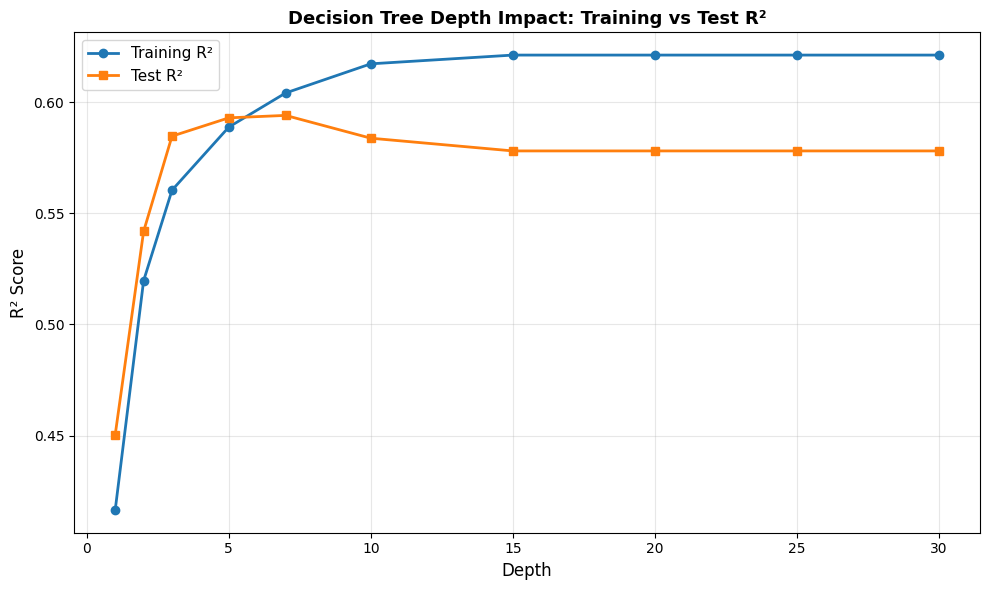

'{"depth":{"0":1,"1":2,"2":3,"3":5,"4":7,"5":10,"6":15,"7":20,"8":25,"9":30},"train":{"0":0.4165232341,"1":0.5196985669,"2":0.5604188787,"3":0.5888249718,"4":0.6041716987,"5":0.6172907631,"6":0.6212285845,"7":0.6212285845,"8":0.6212285845,"9":0.6212285845},"test":{"0":0.4503904026,"1":0.5418856179,"2":0.5847461912,"3":0.5929835263,"4":0.5940872453,"5":0.5838230167,"6":0.5780981739,"7":0.5780981739,"8":0.5780981739,"9":0.5780981739}}'

In [47]:
#q10

results10 = evaluate_depth_impact()

import pandas as pd
import matplotlib.pyplot as plt

plot_df = pd.DataFrame(results10)


plt.figure(figsize=(10, 6))
plt.plot(plot_df['depth'], plot_df['train'], marker='o', label='Training R²', linewidth=2)
plt.plot(plot_df['depth'], plot_df['test'], marker='s', label='Test R²', linewidth=2)

plt.xlabel('Depth', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Decision Tree Depth Impact: Training vs Test R²', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_df.to_json()